## Практика задание 12
Классификация эмоций

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
from torchvision.transforms import v2

transforms_stats = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Resize((224, 224))
])

root = "data/"

"""
stats_data = datasets.ImageFolder(root, transform=transforms_stats)
imgs = [item[0] for item in stats_data]
imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(f"Means R, G, B: {mean_r,mean_g,mean_b}")


std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(f"Std R, G, B: {std_r,std_g,std_b}")
"""

'\nstats_data = datasets.ImageFolder(root, transform=transforms_stats)\nimgs = [item[0] for item in stats_data]\nimgs = torch.stack(imgs, dim=0).numpy()\n\nmean_r = imgs[:,0,:,:].mean()\nmean_g = imgs[:,1,:,:].mean()\nmean_b = imgs[:,2,:,:].mean()\nprint(f"Means R, G, B: {mean_r,mean_g,mean_b}")\n\n\nstd_r = imgs[:,0,:,:].std()\nstd_g = imgs[:,1,:,:].std()\nstd_b = imgs[:,2,:,:].std()\nprint(f"Std R, G, B: {std_r,std_g,std_b}")\n'

In [6]:

from torch.utils.data import random_split

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data = datasets.ImageFolder(root, transform=transforms)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

In [7]:
batch_size = 16
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size)


In [8]:
len(train_dl.dataset)

28171

### Тут начинается модель

In [9]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.gavg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels//16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels//16, in_channels)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        out = self.gavg_pool(x)
        out = out.view(batch_size, channels)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigm(out).view(batch_size, channels, 1, 1)
        return x * out

базис для resnet

In [10]:
class SeResidualBlock(nn.Module):

    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SeResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = nn.ReLU(inplace=True)
        self.seblock = SEBlock(out_channels*4, reduction)

         
        if stride != 1 or in_channels != out_channels*4: # тут мы меняем входной тензор если надо
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.seblock(out)
        out += self.skip_connection(x)
        out = self.relu(out)
        return out


class SeResNet50(nn.Module):
    def __init__(self, block, layers, num_classes, reduction=16):
        super(SeResNet50, self).__init__()
        self.in_channels = 64
        self.conv0 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    

In [11]:
model = SeResNet50(block=SeResidualBlock, layers=[3,4,6,3], num_classes=3)
model.to(device)

SeResNet50(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SeResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (seblock): SEBlock(
        (gavg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Linear(in_features=256, 

## Обучение


*Задаем гиперпараметры*

In [12]:
num_epochs = 10
lr = 0.001

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.999))
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
tr_losses, tr_accs = [], []
for epoch in range(num_epochs):

    epoch_loss, epoch_acc = 0, 0
    for i, batch in tqdm(enumerate(train_dl)):
        torch.cuda.empty_cache()
        img = batch[0].to(device)
        label = batch[1].to(device)
        pred = model(img)
        loss = loss_fn(pred, label)
        epoch_loss += loss.item()
        epoch_acc += (torch.argmax(pred, dim=1) == label).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    tr_loss_to_track = epoch_loss / len(train_dl)
    tr_acc_to_track  = epoch_acc / len(train_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)
    
    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")


1761it [07:14,  4.06it/s]


1-epoch train process is completed!
1-epoch train loss          -> 1.077
1-epoch train accuracy      -> 0.448


1761it [07:06,  4.13it/s]


2-epoch train process is completed!
2-epoch train loss          -> 1.045
2-epoch train accuracy      -> 0.469


1761it [07:52,  3.73it/s]


3-epoch train process is completed!
3-epoch train loss          -> 0.931
3-epoch train accuracy      -> 0.543


1761it [07:04,  4.15it/s]


4-epoch train process is completed!
4-epoch train loss          -> 0.803
4-epoch train accuracy      -> 0.614


1761it [07:00,  4.18it/s]


5-epoch train process is completed!
5-epoch train loss          -> 0.722
5-epoch train accuracy      -> 0.667


1761it [07:09,  4.10it/s]


6-epoch train process is completed!
6-epoch train loss          -> 0.645
6-epoch train accuracy      -> 0.713


1761it [07:10,  4.09it/s]


7-epoch train process is completed!
7-epoch train loss          -> 0.582
7-epoch train accuracy      -> 0.747


1761it [07:11,  4.08it/s]


8-epoch train process is completed!
8-epoch train loss          -> 0.534
8-epoch train accuracy      -> 0.772


1761it [07:09,  4.10it/s]


9-epoch train process is completed!
9-epoch train loss          -> 0.490
9-epoch train accuracy      -> 0.795


1761it [07:01,  4.18it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.446
10-epoch train accuracy      -> 0.814


### Сохраняем модель и рисуем графики

In [14]:
import os
save_prefix, save_dir = "practica12", "saved_models"
os.makedirs(save_dir, exist_ok = True)
torch.save(model.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

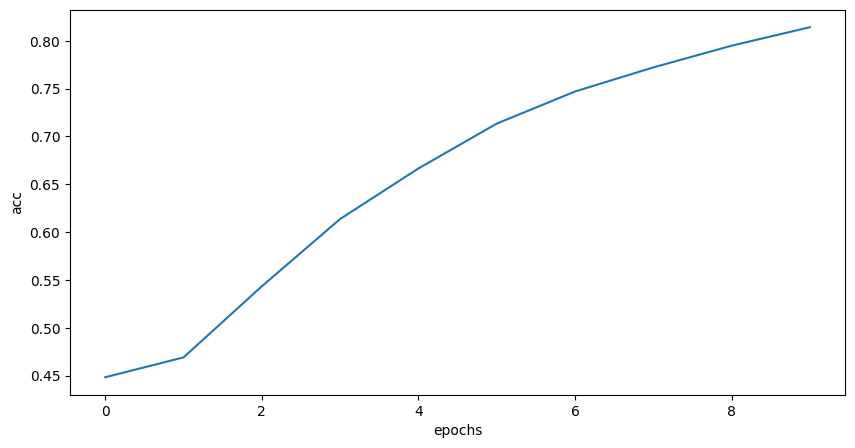

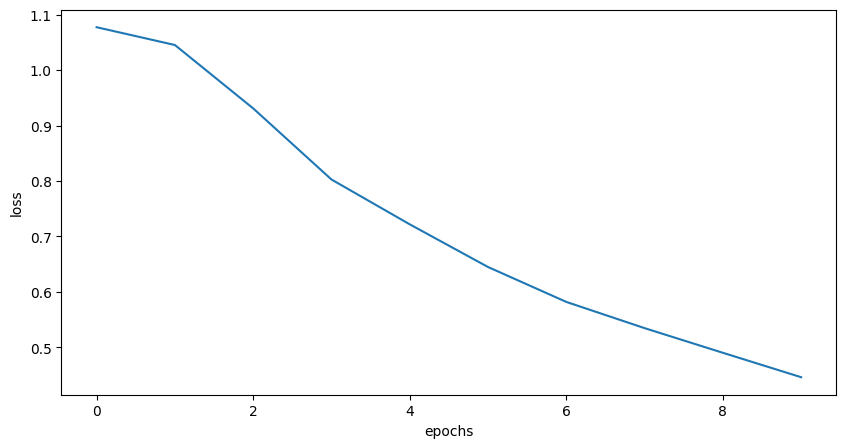

In [15]:
plt.figure(figsize=(10, 5))
plt.xlabel("epochs"); plt.ylabel("acc")
plt.plot([x for x in  range(num_epochs)], tr_accs)
plt.show()

plt.figure(figsize=(10, 5))
plt.xlabel("epochs"); plt.ylabel("loss")
plt.plot([x for x in  range(num_epochs)], tr_losses)
plt.show()

In [19]:
m = SeResNet50(block=SeResidualBlock, layers=[3,4,6,3], num_classes=3)


In [24]:
m.load_state_dict(torch.load('saved_models/practica12_best_model_first.pth'))

<All keys matched successfully>

In [25]:
m.to(device)

SeResNet50(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SeResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (seblock): SEBlock(
        (gavg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Linear(in_features=256, 

In [26]:

epoch_loss, epoch_acc = 0, 0

m.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
    
        img = batch[0].to(device)
        label = batch[1].to(device)
        pred = m(img)
        loss = loss_fn(pred, label)
        epoch_loss += loss.item()
        epoch_acc += (torch.argmax(pred, dim=1) == label).sum().item()
        
print(f"loss -> {epoch_loss/len(test_dl)}")
print(f"acc -> {epoch_acc/len(test_dl.dataset)}")

441it [00:37, 11.73it/s]

loss -> 0.3435810579835963
acc -> 0.86128070424535


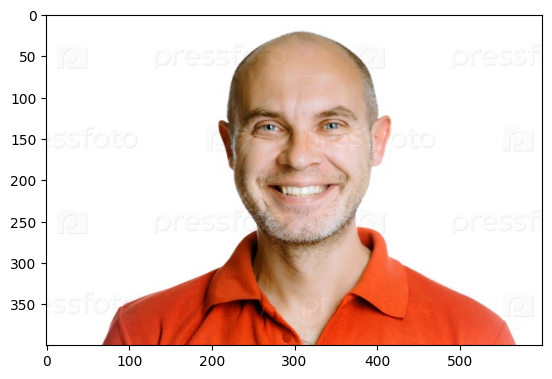

In [42]:
image = Image.open('test.jpg')
plt.imshow(image)
plt.show()
image_tensor = transforms(image_bw)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)

In [71]:
pred = m(image_tensor)


In [72]:
# Предположим, что pred - это тензор с предсказаниями
max_value, max_index = torch.max(pred, dim=1)  # Получаем максимальное значение и индекс

# Теперь используем max_index для доступа к элементам в data.classes
class_label = data.classes[max_index.item()]  # Преобразуем индекс в целое числ
class_label

'happy'